In [ ]:
pip install keras-cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 18.7 MB/s eta 0:00:00


In [ ]:
import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers

Using TensorFlow backend


In [ ]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()
data, dataset_info = tfds.load("oxford_flowers102", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
val_steps_per_epoch = dataset_info.splits["test"].num_examples // BATCH_SIZE

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
IMAGE_SIZE = (224, 224)
num_classes = dataset_info.features["label"].num_classes


def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )
    if split == "test":
        return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


def load_dataset(split="train"):
    dataset = data[split]
    return prepare_dataset(dataset, split)


train_dataset = load_dataset()

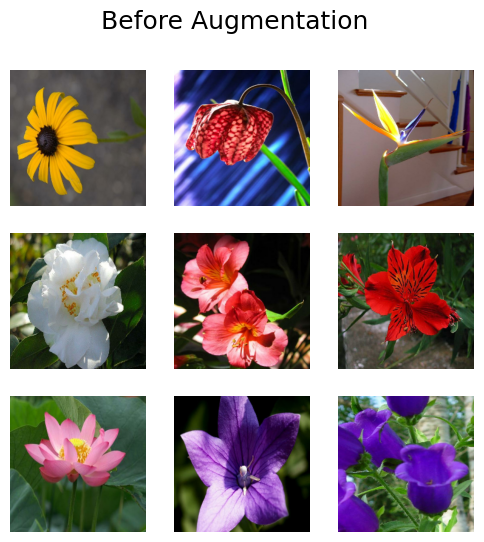

In [ ]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()


visualize_dataset(train_dataset, title="Before Augmentation")

In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)


def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs


train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)

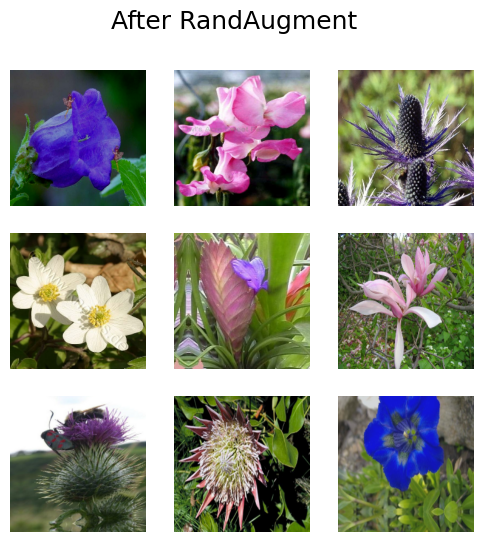

In [ ]:
visualize_dataset(train_dataset, title="After RandAugment")


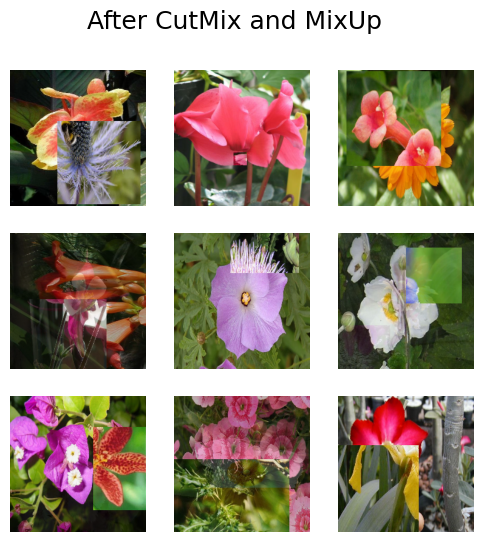

In [ ]:
cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples


train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(train_dataset, title="After CutMix and MixUp")

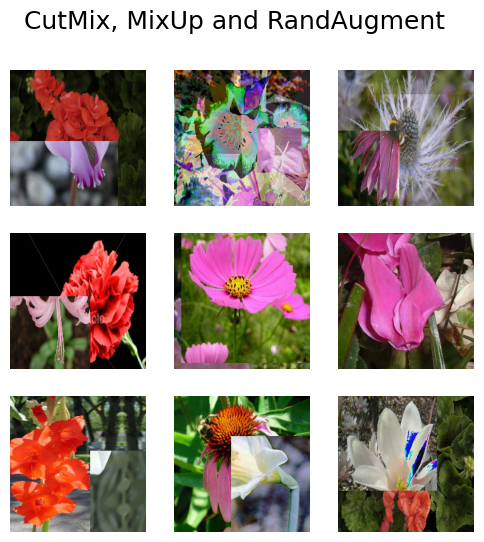

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels


train_dataset = (
    load_dataset()
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
)

visualize_dataset(train_dataset, "CutMix, MixUp and RandAugment")

train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

test_dataset = load_dataset(split="test")
test_dataset = test_dataset.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

In [ ]:
input_shape = IMAGE_SIZE + (3,)


def get_model():
    model = keras_cv.models.ImageClassifier.from_preset(
        "efficientnetv2_s", num_classes=num_classes
    )
    model.compile(
        loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
        optimizer=optimizers.SGD(momentum=0.9),
        metrics=["accuracy"],
    )
    return model

In [ ]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = get_model()
    model.fit(
        train_dataset,
        epochs=200,
        validation_data=test_dataset,
    )

Epoch 1/200
32/32 [==============================] - 79s 606ms/step - loss: 4.7221 - accuracy: 0.0108 - val_loss: 19.0312 - val_accuracy: 0.0102
Epoch 2/200
32/32 [==============================] - 16s 475ms/step - loss: 4.6869 - accuracy: 0.0108 - val_loss: 11.5995 - val_accuracy: 0.0228
Epoch 3/200
32/32 [==============================] - 16s 476ms/step - loss: 4.6717 - accuracy: 0.0127 - val_loss: 6.5771 - val_accuracy: 0.0174
Epoch 4/200
32/32 [==============================] - 15s 471ms/step - loss: 4.6415 - accuracy: 0.0137 - val_loss: 5.5558 - val_accuracy: 0.0263
Epoch 5/200
32/32 [==============================] - 16s 476ms/step - loss: 4.6177 - accuracy: 0.0186 - val_loss: 4.5889 - val_accuracy: 0.0153
Epoch 6/200
32/32 [==============================] - 16s 474ms/step - loss: 4.6288 - accuracy: 0.0147 - val_loss: 10.8028 - val_accuracy: 0.0242
Epoch 7/200
32/32 [==============================] - 16s 477ms/step - loss: 4.6090 - accuracy: 0.0167 - val_loss: 8.4622 - val_accura